# Predictive Models of the Age of Abalones Based on Physical Characteristics

## Summary

In this report, we aim to create an effective model which can predict age of Abalone accurately based on individual physical characteristics. We perform exploratory data analysis and visualization, test both linear and non-linear models on our data, then compare models through regression metrics. 

Authors: Serene Zha, Mehmet Imga, Claudia Liauw, Wendy Frankel

# Introduction

Abalone are marine mollusks that are commercially important in fisheries and aquaculture, particularly in regions such as Tasmania. Estimating the age structure of abalone populations is essential for setting sustainable harvest limits and monitoring stock health. However, the standard method for determining age requires cutting the shell through the cone, staining it, and counting growth rings under a microscope—a destructive, time-consuming, and labor-intensive procedure[1]. Because of this, methods that can infer age from simple, non-destructive measurements of the animal are of practical interest to biologists, fisheries managers, and growers.


Here, we ask whether we can use a machine learning model to predict the age of an abalone from basic physical measurements. Specifically, we will explore linear regression models in Python to relate age to various attributes, including sex, shell length, diameter, height, and several weight measurements. To investigate this question, we use the UCI Abalone dataset, which contains 4,177 abalones with eight predictor variables and a target variable, “Rings.” Each row corresponds to one abalone, and the recorded features include sex (male, female, infant), three shell size measurements (length, diameter, height), and four weight measurements (whole, shucked, viscera, and shell weight). The number of rings serves as a proxy for age, with age in years given approximately by Rings + 1.5 [2], to account for any rings missed in counting (they can be difficult to see). By building and evaluating linear regression models on this dataset, we aim to understand how well these readily obtained physical measurements can predict abalone age and what this implies for practical, non-destructive age estimation.

# Methods

In this section, we describe the data acquisition, preprocessing steps, and modeling approaches used to predict abalone age from physical measurements. We follow the golden rule of machine learning by splitting our data into training and test sets **before** any exploratory analysis or model fitting, ensuring that our test set remains completely unseen until final evaluation.

Our analytical approach consists of the following steps:
1. **Data Acquisition**: Download the dataset programmatically for reproducibility
2. **Data Splitting**: Separate training (80%) and test (20%) sets before any analysis
3. **Data Validation**: Verify data integrity and quality using schema validation
4. **Exploratory Data Analysis**: Understand feature distributions and relationships (using only training data)
5. **Model Selection**: Test both linear and non-linear approaches to capture different potential relationships
6. **Model Evaluation**: Compare models using regression metrics on the held-out test set

### 1. Load Necessary Packages

In [37]:
from ucimlrepo import fetch_ucirepo 
import pandas as pd
import pandera.pandas as pa
import altair as alt
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.compose import make_column_transformer
from sklearn.preprocessing import OneHotEncoder, StandardScaler, PolynomialFeatures
from sklearn.pipeline import make_pipeline
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import RandomForestRegressor
from sklearn.svm import SVR
from sklearn.metrics import mean_squared_error, r2_score

### 2. Load Data

In [38]:
import requests
import zipfile

url = "https://archive.ics.uci.edu/static/public/1/abalone.zip"

request = requests.get(url)
with open("../data/raw/abalone.zip", 'wb') as f:
    f.write(request.content)

with zipfile.ZipFile("../data/raw/abalone.zip", 'r') as zip_ref:
    zip_ref.extractall("../data/raw")

In [39]:
 # fetch dataset 
abalone = fetch_ucirepo(id=1) 

# Extract features and targets
X = abalone.data.features
y = abalone.data.targets

### 3. Data Wrangling and Cleaning

#### Split Data

Following the **golden rule of machine learning**, we split the data into training (80%) and test (20%) sets **before** performing any exploratory analysis or model fitting. This ensures that our test set remains completely unseen during the entire modeling process, giving us an unbiased estimate of how well our models will generalize to new, unseen abalones. All subsequent exploratory data analysis and visualizations use only the training data.

In [40]:
# Split Data (Same random_state as baseline for comparison)
X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=522
)

train_df = pd.concat([X_train, y_train], axis=1)
test_df = pd.concat([X_test, y_test], axis=1)

# ravel y for sklearn
y_train = y_train.values.ravel()
y_test = y_test.values.ravel()

print("Data loaded and split.")

train_df

Data loaded and split.


Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
2194   I   0.430     0.325   0.110        0.3675          0.1355   
3996   I   0.315     0.230   0.000        0.1340          0.0575   
3329   F   0.545     0.435   0.150        0.6855          0.2905   
492    F   0.655     0.510   0.155        1.2895          0.5345   
241    I   0.270     0.200   0.070        0.1000          0.0340   
...   ..     ...       ...     ...           ...             ...   
3956   F   0.515     0.395   0.140        0.6860          0.2810   
154    F   0.565     0.450   0.135        0.9885          0.3870   
3360   F   0.580     0.440   0.175        1.0730          0.4005   
1899   M   0.575     0.450   0.130        0.7850          0.3180   
3988   M   0.665     0.515   0.165        1.3855          0.6210   

      Viscera_weight  Shell_weight  Rings  
2194          0.0935        0.1200     13  
3996          0.0285        0.3505      6  
3329          0.1450        0.2250     10  
492           0.2855        0.4100     11  
241           0.0245        0.0350      5  
...              ...           ...    ...  
3956          0.1255        0.2200     12  
154           0.1495        0.3100     12  
3360          0.2345        0.3350     19  
1899          0.1930        0.2265      9  
3988          0.3020        0.3445      8  

[3341 rows x 9 columns]

#### Save Data

In [41]:
train_df.to_csv('../data/processed/abalone_train.csv', index=False)
test_df.to_csv('../data/processed/abalone_test.csv', index=False)

### 4. Data Validation

Before proceeding with analysis, we validate the data quality using Pandera schema validation. This ensures our data meets expected constraints (correct types, reasonable value ranges, no missing values in critical columns) and helps catch any data quality issues early in the pipeline.

#### Correct Data File Format

In [42]:
assert isinstance(train_df, pd.DataFrame), "Expected 'train_df' to be a Pandas DataFrame"

#### Data Validation Using Panderas

In [43]:
#This schema checks column types, and that there are no NULL values in the feature columns. 
 
schema = pa.DataFrameSchema({
    "Sex": pa.Column(str, nullable=False),
    "Length": pa.Column(float, nullable=False),
    "Diameter": pa.Column(float, nullable=False),
    "Height": pa.Column(float, nullable=False),
    "Whole_weight": pa.Column(float, nullable=False),
    "Shucked_weight": pa.Column(float, nullable=False),
    "Viscera_weight": pa.Column(float, nullable=False),
    "Shell_weight": pa.Column(float, nullable=False),
    "Rings": pa.Column(int)   
}
)

schema.validate(train_df, lazy=True)

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
2194   I   0.430     0.325   0.110        0.3675          0.1355   
3996   I   0.315     0.230   0.000        0.1340          0.0575   
3329   F   0.545     0.435   0.150        0.6855          0.2905   
492    F   0.655     0.510   0.155        1.2895          0.5345   
241    I   0.270     0.200   0.070        0.1000          0.0340   
...   ..     ...       ...     ...           ...             ...   
3956   F   0.515     0.395   0.140        0.6860          0.2810   
154    F   0.565     0.450   0.135        0.9885          0.3870   
3360   F   0.580     0.440   0.175        1.0730          0.4005   
1899   M   0.575     0.450   0.130        0.7850          0.3180   
3988   M   0.665     0.515   0.165        1.3855          0.6210   

      Viscera_weight  Shell_weight  Rings  
2194          0.0935        0.1200     13  
3996          0.0285        0.3505      6  
3329          0.1450        0.2250     10  
492           0.2855        0.4100     11  
241           0.0245        0.0350      5  
...              ...           ...    ...  
3956          0.1255        0.2200     12  
154           0.1495        0.3100     12  
3360          0.2345        0.3350     19  
1899          0.1930        0.2265      9  
3988          0.3020        0.3445      8  

[3341 rows x 9 columns]

In [44]:
#This checks that there are not more than 5% missing values in the target column

schema = pa.DataFrameSchema(
    {
        "Rings": pa.Column(int,
                                pa.Check(lambda s: s.isna().mean() <= 0.05,
                                    element_wise=False,
                                    error="Too many null values in 'Rings' column."),
                                nullable=True)
    }
)

schema.validate(train_df, lazy=True)

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
2194   I   0.430     0.325   0.110        0.3675          0.1355   
3996   I   0.315     0.230   0.000        0.1340          0.0575   
3329   F   0.545     0.435   0.150        0.6855          0.2905   
492    F   0.655     0.510   0.155        1.2895          0.5345   
241    I   0.270     0.200   0.070        0.1000          0.0340   
...   ..     ...       ...     ...           ...             ...   
3956   F   0.515     0.395   0.140        0.6860          0.2810   
154    F   0.565     0.450   0.135        0.9885          0.3870   
3360   F   0.580     0.440   0.175        1.0730          0.4005   
1899   M   0.575     0.450   0.130        0.7850          0.3180   
3988   M   0.665     0.515   0.165        1.3855          0.6210   

      Viscera_weight  Shell_weight  Rings  
2194          0.0935        0.1200     13  
3996          0.0285        0.3505      6  
3329          0.1450        0.2250     10  
492           0.2855        0.4100     11  
241           0.0245        0.0350      5  
...              ...           ...    ...  
3956          0.1255        0.2200     12  
154           0.1495        0.3100     12  
3360          0.2345        0.3350     19  
1899          0.1930        0.2265      9  
3988          0.3020        0.3445      8  

[3341 rows x 9 columns]

In [45]:
# checking that numeric features are within range; no extreme outliers

schema = pa.DataFrameSchema(
    {
        "Length": pa.Column(float, pa.Check.between(0, 1)),
        "Diameter": pa.Column(float, pa.Check.between(0, 1)),
        "Height": pa.Column(float, pa.Check.between(0, 1)),
        "Whole_weight": pa.Column(float, pa.Check.between(0, 3)),
        "Shucked_weight": pa.Column(float, pa.Check.between(0, 2)),
        "Viscera_weight": pa.Column(float, pa.Check.between(0, 1)),
        "Shell_weight": pa.Column(float, pa.Check.between(0, 1.10)),
        "Rings": pa.Column(int, pa.Check.between(0, 30))
    }
)

schema.validate(train_df, lazy=True)

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
2194   I   0.430     0.325   0.110        0.3675          0.1355   
3996   I   0.315     0.230   0.000        0.1340          0.0575   
3329   F   0.545     0.435   0.150        0.6855          0.2905   
492    F   0.655     0.510   0.155        1.2895          0.5345   
241    I   0.270     0.200   0.070        0.1000          0.0340   
...   ..     ...       ...     ...           ...             ...   
3956   F   0.515     0.395   0.140        0.6860          0.2810   
154    F   0.565     0.450   0.135        0.9885          0.3870   
3360   F   0.580     0.440   0.175        1.0730          0.4005   
1899   M   0.575     0.450   0.130        0.7850          0.3180   
3988   M   0.665     0.515   0.165        1.3855          0.6210   

      Viscera_weight  Shell_weight  Rings  
2194          0.0935        0.1200     13  
3996          0.0285        0.3505      6  
3329          0.1450        0.2250     10  
492           0.2855        0.4100     11  
241           0.0245        0.0350      5  
...              ...           ...    ...  
3956          0.1255        0.2200     12  
154           0.1495        0.3100     12  
3360          0.2345        0.3350     19  
1899          0.1930        0.2265      9  
3988          0.3020        0.3445      8  

[3341 rows x 9 columns]

In [46]:
#checking that the 'sex' column only has the values M, F, or I

schema = pa.DataFrameSchema(
    {
        "Sex": pa.Column(str, pa.Check.isin(["M", "F", "I"]), nullable = False)
    }
)

schema.validate(train_df, lazy=True)

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
2194   I   0.430     0.325   0.110        0.3675          0.1355   
3996   I   0.315     0.230   0.000        0.1340          0.0575   
3329   F   0.545     0.435   0.150        0.6855          0.2905   
492    F   0.655     0.510   0.155        1.2895          0.5345   
241    I   0.270     0.200   0.070        0.1000          0.0340   
...   ..     ...       ...     ...           ...             ...   
3956   F   0.515     0.395   0.140        0.6860          0.2810   
154    F   0.565     0.450   0.135        0.9885          0.3870   
3360   F   0.580     0.440   0.175        1.0730          0.4005   
1899   M   0.575     0.450   0.130        0.7850          0.3180   
3988   M   0.665     0.515   0.165        1.3855          0.6210   

      Viscera_weight  Shell_weight  Rings  
2194          0.0935        0.1200     13  
3996          0.0285        0.3505      6  
3329          0.1450        0.2250     10  
492           0.2855        0.4100     11  
241           0.0245        0.0350      5  
...              ...           ...    ...  
3956          0.1255        0.2200     12  
154           0.1495        0.3100     12  
3360          0.2345        0.3350     19  
1899          0.1930        0.2265      9  
3988          0.3020        0.3445      8  

[3341 rows x 9 columns]

In [47]:
#checking for duplicates

schema = pa.DataFrameSchema(
    checks=[
        pa.Check(lambda train_df: ~train_df.duplicated().any(), error="Duplicate rows found.")
    ]
)

schema.validate(train_df, lazy=True)

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
2194   I   0.430     0.325   0.110        0.3675          0.1355   
3996   I   0.315     0.230   0.000        0.1340          0.0575   
3329   F   0.545     0.435   0.150        0.6855          0.2905   
492    F   0.655     0.510   0.155        1.2895          0.5345   
241    I   0.270     0.200   0.070        0.1000          0.0340   
...   ..     ...       ...     ...           ...             ...   
3956   F   0.515     0.395   0.140        0.6860          0.2810   
154    F   0.565     0.450   0.135        0.9885          0.3870   
3360   F   0.580     0.440   0.175        1.0730          0.4005   
1899   M   0.575     0.450   0.130        0.7850          0.3180   
3988   M   0.665     0.515   0.165        1.3855          0.6210   

      Viscera_weight  Shell_weight  Rings  
2194          0.0935        0.1200     13  
3996          0.0285        0.3505      6  
3329          0.1450        0.2250     10  
492           0.2855        0.4100     11  
241           0.0245        0.0350      5  
...              ...           ...    ...  
3956          0.1255        0.2200     12  
154           0.1495        0.3100     12  
3360          0.2345        0.3350     19  
1899          0.1930        0.2265      9  
3988          0.3020        0.3445      8  

[3341 rows x 9 columns]

In [48]:
#checking for empty observations

schema = pa.DataFrameSchema(
    checks=[
        pa.Check(lambda train_df: ~train_df.duplicated().any(), error="Duplicate rows found."),
        pa.Check(lambda train_df: ~(train_df.isna().all(axis=1)).any(), error="Empty rows found.")
    ]
)

schema.validate(train_df, lazy=True)

Sex  Length  Diameter  Height  Whole_weight  Shucked_weight  \
2194   I   0.430     0.325   0.110        0.3675          0.1355   
3996   I   0.315     0.230   0.000        0.1340          0.0575   
3329   F   0.545     0.435   0.150        0.6855          0.2905   
492    F   0.655     0.510   0.155        1.2895          0.5345   
241    I   0.270     0.200   0.070        0.1000          0.0340   
...   ..     ...       ...     ...           ...             ...   
3956   F   0.515     0.395   0.140        0.6860          0.2810   
154    F   0.565     0.450   0.135        0.9885          0.3870   
3360   F   0.580     0.440   0.175        1.0730          0.4005   
1899   M   0.575     0.450   0.130        0.7850          0.3180   
3988   M   0.665     0.515   0.165        1.3855          0.6210   

      Viscera_weight  Shell_weight  Rings  
2194          0.0935        0.1200     13  
3996          0.0285        0.3505      6  
3329          0.1450        0.2250     10  
492           0.2855        0.4100     11  
241           0.0245        0.0350      5  
...              ...           ...    ...  
3956          0.1255        0.2200     12  
154           0.1495        0.3100     12  
3360          0.2345        0.3350     19  
1899          0.1930        0.2265      9  
3988          0.3020        0.3445      8  

[3341 rows x 9 columns]

#### Distribution of Target

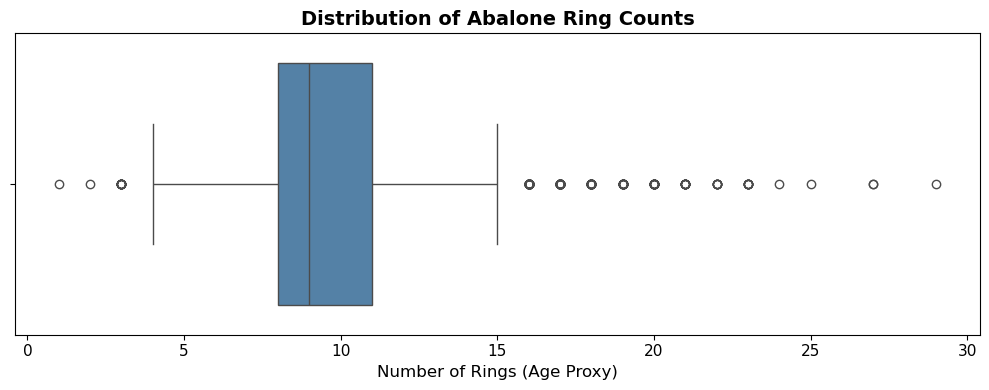

In [49]:
# Create boxplot with improved formatting
fig, ax = plt.subplots(figsize=(10, 4))
sns.boxplot(data=train_df, x='Rings', ax=ax, color='steelblue')
ax.set_xlabel('Number of Rings (Age Proxy)', fontsize=12)
ax.set_title('Distribution of Abalone Ring Counts', fontsize=14, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)
plt.tight_layout()
plt.show()

**Figure 1**: Boxplot showing the distribution and outliers of target variable Rings. 

**Observation**: There are outliers on the high end (older abalones), but no anomalous values below 0 or unreasonably high values. The outliers represent legitimately old abalones rather than data errors.

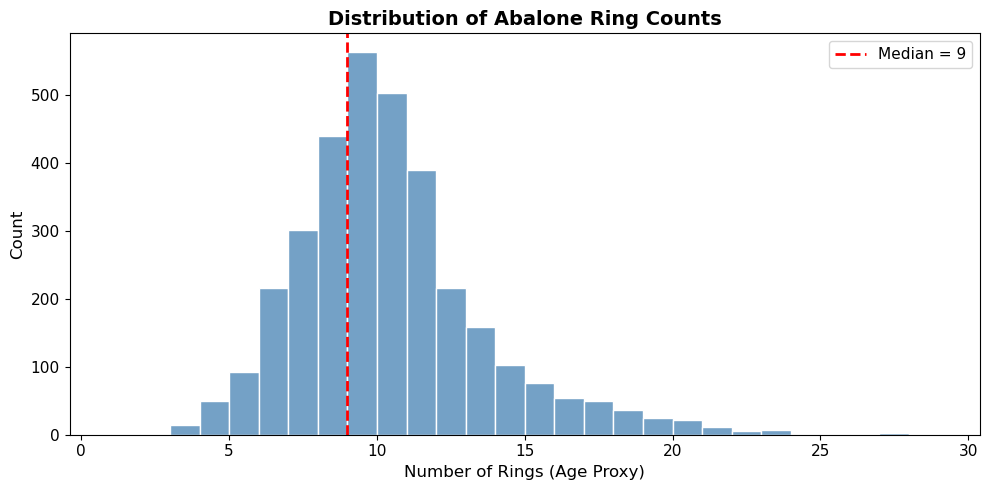

In [50]:
# Create histogram with improved formatting
fig, ax = plt.subplots(figsize=(10, 5))
sns.histplot(data=train_df, x='Rings', binwidth=1, ax=ax, color='steelblue', edgecolor='white')
ax.set_xlabel('Number of Rings (Age Proxy)', fontsize=12)
ax.set_ylabel('Count', fontsize=12)
ax.set_title('Distribution of Abalone Ring Counts', fontsize=14, fontweight='bold')
ax.tick_params(axis='both', labelsize=11)

# Add vertical line for median
median_rings = train_df['Rings'].median()
ax.axvline(median_rings, color='red', linestyle='--', linewidth=2, label=f'Median = {median_rings:.0f}')
ax.legend(fontsize=11)
plt.tight_layout()
plt.show()

**Figure 2**: Histogram showing the distribution of target variable Rings. 

**Observation**: The distribution shows a slight right skew, with most abalones having between 7-12 rings. This suggests age distribution in the sample is not perfectly normal, which may affect model assumptions.

In [51]:
from scipy.stats import shapiro
normal_pvalue = shapiro(train_df.Rings).pvalue
try:
    assert normal_pvalue > 0.05
except AssertionError:
    print(f"Target variable is not normal! Shapiro p-value: {normal_pvalue}")

Target variable is not normal! Shapiro p-value: 1.7121391423967805e-36


#### Correlations

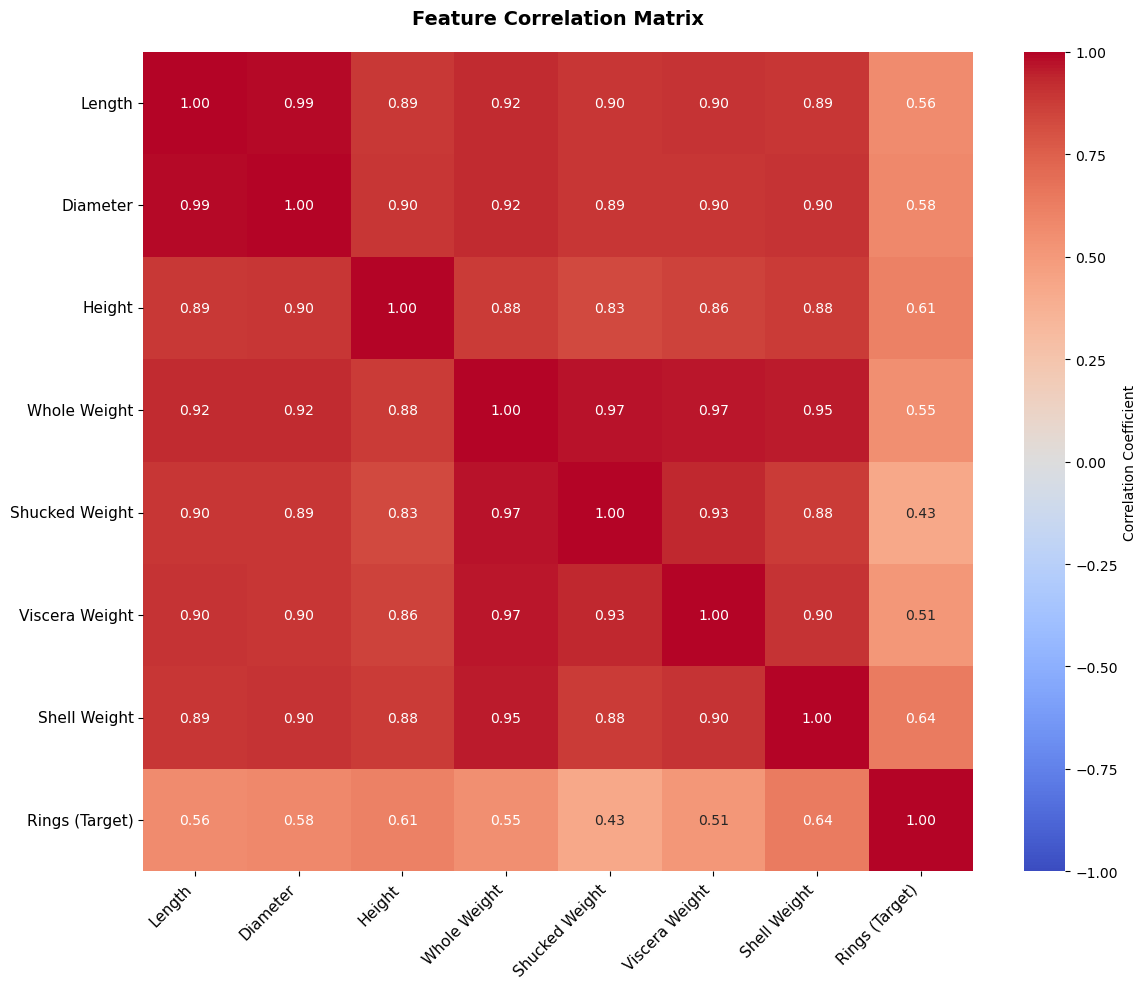

In [52]:
# Create correlation matrix with human-readable labels
corr_matrix = train_df.select_dtypes(include=['float64', 'int64']).corr()

# Map column names to human-readable labels
label_map = {
    'Length': 'Length',
    'Diameter': 'Diameter', 
    'Height': 'Height',
    'Whole_weight': 'Whole Weight',
    'Shucked_weight': 'Shucked Weight',
    'Viscera_weight': 'Viscera Weight',
    'Shell_weight': 'Shell Weight',
    'Rings': 'Rings (Target)'
}

# Rename index and columns
corr_matrix_display = corr_matrix.rename(index=label_map, columns=label_map)

# Create heatmap with improved formatting
fig, ax = plt.subplots(figsize=(12, 10))
sns.heatmap(corr_matrix_display, annot=True, fmt='.2f', vmin=-1, vmax=1, 
            cmap='coolwarm', ax=ax, annot_kws={'size': 10},
            cbar_kws={'label': 'Correlation Coefficient'})
ax.set_title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
ax.tick_params(axis='both', labelsize=11)
plt.xticks(rotation=45, ha='right')
plt.yticks(rotation=0)
plt.tight_layout()
plt.show()

**Figure 3**: Correlation heatmap showing relationships between numerical features and the target variable (Rings). 

**Observation**: Features show moderate positive correlations with Rings (0.5-0.6), indicating that physical measurements do contain predictive signal for age. However, there are high correlations among the features themselves (>0.9 between weights and dimensions), suggesting multicollinearity. This could affect linear regression coefficient interpretation, though it doesn't necessarily harm prediction accuracy. Non-linear models like Random Forest are less sensitive to multicollinearity.

In [53]:
threshold = 0.9
exceeds_threshold = [(corr_matrix.index[i], corr_matrix.columns[j], corr_matrix.iloc[i, j].round(4)) 
 for i, j in np.argwhere(corr_matrix > threshold)]
try:
    assert len(exceeds_threshold) == 0
except AssertionError:
    print(f"Anomalous correlations above {threshold}!")
    print(exceeds_threshold)

Anomalous correlations above 0.9!
[('Length', 'Length', np.float64(1.0)), ('Length', 'Diameter', np.float64(0.9867)), ('Length', 'Whole_weight', np.float64(0.9237)), ('Length', 'Viscera_weight', np.float64(0.9009)), ('Diameter', 'Length', np.float64(0.9867)), ('Diameter', 'Diameter', np.float64(1.0)), ('Diameter', 'Whole_weight', np.float64(0.9238)), ('Diameter', 'Shell_weight', np.float64(0.9024)), ('Height', 'Height', np.float64(1.0)), ('Whole_weight', 'Length', np.float64(0.9237)), ('Whole_weight', 'Diameter', np.float64(0.9238)), ('Whole_weight', 'Whole_weight', np.float64(1.0)), ('Whole_weight', 'Shucked_weight', np.float64(0.9696)), ('Whole_weight', 'Viscera_weight', np.float64(0.9662)), ('Whole_weight', 'Shell_weight', np.float64(0.9544)), ('Shucked_weight', 'Whole_weight', np.float64(0.9696)), ('Shucked_weight', 'Shucked_weight', np.float64(1.0)), ('Shucked_weight', 'Viscera_weight', np.float64(0.9336)), ('Viscera_weight', 'Length', np.float64(0.9009)), ('Viscera_weight', 'Whol

### 5. Exploratory Data Analysis (EDA)

The exploratory analysis below is performed **only on the training set** to avoid any data leakage from the test set. This ensures our understanding of the data and any decisions made based on EDA do not inadvertently incorporate information from the held-out test data.

#### Summary
* Mostly numerical variables except sex.
* No missing values.
* Target (Rings) ranges from 1 to 29. Mostly normal, slight right skew.
* Sex needs to be one-hot encoded, the rest should be scaled.
* Numeric variables are moderately positively correlated with target.

In [54]:
missing_values = train_df.isnull().sum()
print("Missing values per column:", missing_values[missing_values > 0])

Missing values per column: Series([], dtype: int64)


In [55]:
train_df.info()

<class 'pandas.core.frame.DataFrame'>
Index: 3341 entries, 2194 to 3988
Data columns (total 9 columns):
 #   Column          Non-Null Count  Dtype  
---  ------          --------------  -----  
 0   Sex             3341 non-null   object 
 1   Length          3341 non-null   float64
 2   Diameter        3341 non-null   float64
 3   Height          3341 non-null   float64
 4   Whole_weight    3341 non-null   float64
 5   Shucked_weight  3341 non-null   float64
 6   Viscera_weight  3341 non-null   float64
 7   Shell_weight    3341 non-null   float64
 8   Rings           3341 non-null   int64  
dtypes: float64(7), int64(1), object(1)
memory usage: 261.0+ KB


In [56]:
train_df.describe().round(2)

Length  Diameter   Height  Whole_weight  Shucked_weight  \
count  3341.00   3341.00  3341.00       3341.00         3341.00   
mean      0.52      0.41     0.14          0.82            0.36   
std       0.12      0.10     0.04          0.49            0.22   
min       0.08      0.06     0.00          0.00            0.00   
25%       0.45      0.35     0.12          0.44            0.18   
50%       0.55      0.42     0.14          0.80            0.33   
75%       0.62      0.48     0.16          1.14            0.50   
max       0.82      0.65     0.52          2.83            1.49   

       Viscera_weight  Shell_weight    Rings  
count         3341.00       3341.00  3341.00  
mean             0.18          0.24     9.93  
std              0.11          0.14     3.25  
min              0.00          0.00     1.00  
25%              0.09          0.13     8.00  
50%              0.17          0.23     9.00  
75%              0.25          0.32    11.00  
max              0.76          1.00    29.00

#### Visualisation

In [57]:
from ydata_profiling import ProfileReport
ProfileReport(train_df)

Summarize dataset:   0%|          | 0/5 [00:00<?, ?it/s]

100%|██████████| 9/9 [00:00<00:00, 31145.82it/s]


Generate report structure:   0%|          | 0/1 [00:00<?, ?it/s]

Render HTML:   0%|          | 0/1 [00:00<?, ?it/s]

Below, we investigate the possible relationship between sex of adults (M/F), Infants, and number of rings, as the relationship may differ between those categories.

In [58]:
# Create a copy with human-readable Sex labels for visualization
train_df_viz = train_df.copy()
sex_label_map = {'M': 'Male', 'F': 'Female', 'I': 'Infant'}
train_df_viz['Sex Category'] = train_df_viz['Sex'].map(sex_label_map)

# Scatter plot with regression lines
base = alt.Chart(train_df_viz).mark_circle(opacity=0.4, size=60).encode(
    x=alt.X('Shell_weight:Q', 
            title='Shell Weight (grams)',
            scale=alt.Scale(zero=False)),
    y=alt.Y('Rings:Q', 
            title='Number of Rings (Age Proxy)'),
    color=alt.Color('Sex Category:N', 
                    title='Sex Category',
                    scale=alt.Scale(domain=['Male', 'Female', 'Infant'],
                                   range=['#1f77b4', '#ff7f0e', '#2ca02c']),
                    legend=alt.Legend(orient='top-right'))
)

lines = base.transform_regression(
    'Shell_weight', 'Rings', groupby=['Sex Category']
).mark_line(strokeWidth=3).encode(
    color=alt.Color('Sex Category:N', 
                    title='Sex Category',
                    legend=None)
)

(base + lines).properties(
    title=alt.TitleParams(
        text='Relationship Between Shell Weight and Ring Count by Sex',
        fontSize=14,
        fontWeight='bold'
    ),
    width=550,
    height=400
).configure_axis(
    labelFontSize=12,
    titleFontSize=13
).configure_legend(
    titleFontSize=12,
    labelFontSize=11
)

alt.LayerChart(...)

**Figure 4**: Number of rings (target variable) by shell weight (grams), grouped by Sex: Male (M), Female (F), and Infant (I). Linear regression lines for each group are shown.

**Observation**: The relationship between shell weight and age appears roughly linear within each sex category, but the slopes differ—particularly for Infants, which show a steeper growth curve. This suggests that age-weight relationships may depend on developmental stage, supporting the inclusion of Sex as a feature in our models.

### 6. Model Selection and Training

#### Why These Models?

To address our research question—whether physical measurements can predict abalone age—we test three modeling approaches that span the complexity spectrum:

1. **Linear Regression (Baseline)**: We start with linear regression because it provides an interpretable baseline. If a linear relationship exists between physical measurements and age, this model will capture it. The coefficients also help us understand which features contribute most to predicting age, which is valuable for biological interpretation.

2. **Random Forest Regressor**: We include this ensemble method because biological growth patterns are often non-linear. Random Forest can capture complex interactions between features (e.g., the relationship between weight and age may differ for different shell sizes) without requiring us to manually specify these interactions.

3. **Support Vector Regression (SVR)**: We test SVR with an RBF kernel as another non-linear approach. SVR is effective when relationships are complex but the number of features is moderate, as in our case.

#### Evaluation Metrics

We evaluate models using two complementary metrics:
- **Root Mean Squared Error (RMSE)**: Measures the average prediction error in the same units as the target (rings). Lower RMSE indicates better predictive accuracy. We use RMSE rather than MSE because it's more interpretable—an RMSE of 2.0 means predictions are off by about 2 rings on average.
- **R² (Coefficient of Determination)**: Represents the proportion of variance in the target explained by the model. R² = 1.0 means perfect prediction; R² = 0 means the model is no better than predicting the mean. This helps us understand how much of the age variation is captured by physical measurements.

#### Model A: Linear Regression (Baseline)

We construct a preprocessing pipeline that:
1. One-hot encodes the categorical Sex feature (to handle the three categories: M, F, I)
2. Standardizes numerical features (important for comparing coefficients)
3. Fits a Linear Regression model

In [59]:
# Define features
numeric_features = ['Length', 'Diameter', 'Height', 'Whole_weight', 'Shucked_weight', 'Viscera_weight', 'Shell_weight']
categorical_features = ['Sex']

# Create preprocessor
preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features),
    (OneHotEncoder(drop='if_binary'), categorical_features)
)

# Create and fit pipeline
lr_model = make_pipeline(preprocessor, LinearRegression())
lr_model.fit(X_train, y_train)

# Make predictions
lr_y_pred = lr_model.predict(X_test)

# Results

In this section, we present the results of our model training and evaluation. All models were trained exclusively on the training set, and evaluation metrics are computed on the held-out test set to ensure unbiased performance estimates.

### 7. Linear Regression Results

We evaluate the linear regression model by examining both quantitative metrics and visual diagnostics. The scatter plot below compares predicted vs. actual ring counts—points along the diagonal indicate accurate predictions.

In [60]:
# Calculate metrics
lr_rmse = np.sqrt(mean_squared_error(y_test, lr_y_pred))
lr_r2 = r2_score(y_test, lr_y_pred)

print(f"Linear Regression Model Performance:")
print(f"  Root Mean Squared Error (RMSE): {lr_rmse:.4f} rings")
print(f"  R-squared (R²): {lr_r2:.4f} ({lr_r2*100:.1f}% variance explained)")

# Visualization with improved formatting
results_df = pd.DataFrame({
    'Actual Rings': y_test.flatten(),
    'Predicted Rings': lr_y_pred.flatten()
})

# Scatter plot of predictions
pred_chart = alt.Chart(results_df).mark_circle(opacity=0.5, size=60, color='steelblue').encode(
    x=alt.X('Actual Rings:Q', 
            title='Actual Number of Rings',
            scale=alt.Scale(domain=[0, 30])),
    y=alt.Y('Predicted Rings:Q', 
            title='Predicted Number of Rings',
            scale=alt.Scale(domain=[0, 30]))
).properties(
    width=500,
    height=500
)

# Perfect prediction line (y = x)
perfect_line_df = pd.DataFrame({'x': [0, 30], 'y': [0, 30], 'label': ['Perfect Prediction (y = x)', 'Perfect Prediction (y = x)']})
perfect_line = alt.Chart(perfect_line_df).mark_line(
    color='red', 
    strokeDash=[5,5],
    strokeWidth=2
).encode(
    x='x:Q',
    y='y:Q'
)

# Create legend for the line manually
legend_data = pd.DataFrame({
    'x': [15], 'y': [15], 
    'Legend': ['Perfect Prediction (y = x)']
})

# Combine chart with title including metrics
combined_chart = (pred_chart + perfect_line).properties(
    title=alt.TitleParams(
        text=f'Linear Regression: Actual vs Predicted Ring Count',
        subtitle=f'R² = {lr_r2:.3f}, RMSE = {lr_rmse:.2f} rings',
        fontSize=14,
        fontWeight='bold',
        subtitleFontSize=12
    )
).configure_axis(
    labelFontSize=12,
    titleFontSize=13
)

combined_chart

Linear Regression Model Performance:
  Root Mean Squared Error (RMSE): 2.3419 rings
  R-squared (R²): 0.4427 (44.3% variance explained)


alt.LayerChart(...)

**Figure 5**: Actual Rings (x-axis) vs Predicted Rings (y-axis) for the linear regression model. The red dashed line represents perfect prediction (y = x). Points close to this line indicate accurate predictions, while deviations show prediction errors.

**Interpretation**: The model tends to under-predict for older abalones (high ring counts) and shows considerable scatter throughout, consistent with the moderate R² value of ~0.44. This suggests that linear relationships alone cannot fully capture how age relates to physical measurements.

In [61]:
# Extracting feature names from the preprocessor
ohe = lr_model.named_steps['columntransformer'].named_transformers_['onehotencoder']
ohe_features = list(ohe.get_feature_names_out(categorical_features))

# Combining to get all features
all_features = numeric_features + ohe_features

# Extract coefficients from linear regression
coefficients = lr_model.named_steps['linearregression'].coef_

# Create DataFrame with human-readable feature names
feature_label_map = {
    'Length': 'Length',
    'Diameter': 'Diameter',
    'Height': 'Height',
    'Whole_weight': 'Whole Weight',
    'Shucked_weight': 'Shucked Weight',
    'Viscera_weight': 'Viscera Weight',
    'Shell_weight': 'Shell Weight',
    'Sex_F': 'Sex: Female',
    'Sex_I': 'Sex: Infant',
    'Sex_M': 'Sex: Male'
}

coef_df = pd.DataFrame({
    "Feature": all_features,
    "Coefficient": coefficients
})

# Map to human-readable names
coef_df['Feature Name'] = coef_df['Feature'].map(feature_label_map)
coef_df = coef_df[['Feature Name', 'Coefficient']].sort_values("Coefficient", ascending=False)
coef_df['Coefficient'] = coef_df['Coefficient'].round(4)

# Display styled table
print("Table 1: Linear Regression Coefficients (Standardized Features)")
print("=" * 50)
coef_df_display = coef_df.reset_index(drop=True)
coef_df_display.index = coef_df_display.index + 1  # Start index at 1
coef_df_display.style.bar(subset=['Coefficient'], align='mid', color=['#d65f5f', '#5fba7d'])

Table 1: Linear Regression Coefficients (Standardized Features)


**Table 1**: Linear Regression coefficient values showing the estimated contribution of each feature to the predicted ring count after standardization and one-hot encoding.

**Interpretation**: Since features are standardized, coefficient magnitudes are comparable. Whole weight shows the strongest positive association with age, while Shucked weight has a strong negative coefficient. This counterintuitive pattern (since both weights should increase with age) is likely due to multicollinearity among weight features—when correlated features are included together, their individual coefficients can be difficult to interpret. This further motivates our use of non-linear models that are less sensitive to multicollinearity.

### 8. Non-Linear Model Results

Given that the linear model explains only about 44% of the variance (R² ≈ 0.44), we now test non-linear models to see if they can capture more complex relationships in the data.

#### Model B: Random Forest Regressor

Random Forest builds multiple decision trees on bootstrapped samples and averages their predictions. This approach can capture non-linear patterns and feature interactions without overfitting. We use 100 trees with default hyperparameters as a reasonable starting point.

In [62]:
rf_preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features), # Scaling isn't strictly necessary for RF, but good practice
    (OneHotEncoder(drop='if_binary'), categorical_features)
)

rf_model = make_pipeline(rf_preprocessor, RandomForestRegressor(n_estimators=100, random_state=522))
rf_model.fit(X_train, y_train)
y_pred_rf = rf_model.predict(X_test)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
r2_rf = r2_score(y_test, y_pred_rf)

print(f"Random Forest - RMSE: {rmse_rf:.4f}, R2: {r2_rf:.4f}")

Random Forest - RMSE: 2.1817, R2: 0.5163


#### Model C: Support Vector Regression (SVR)

SVR with a Radial Basis Function (RBF) kernel maps the data into a higher-dimensional space where non-linear relationships become linear. This approach is particularly effective when the number of features is moderate. Note that feature scaling is critical for SVR performance, which is why we standardize all numeric features in our preprocessing pipeline.

In [63]:
svr_preprocessor = make_column_transformer(
    (StandardScaler(), numeric_features), # Scaling is CRITICAL for SVR
    (OneHotEncoder(drop='if_binary'), categorical_features)
)

svr_model = make_pipeline(svr_preprocessor, SVR(kernel='rbf', C=1.0, epsilon=0.1))
svr_model.fit(X_train, y_train)
y_pred_svr = svr_model.predict(X_test)

rmse_svr = np.sqrt(mean_squared_error(y_test, y_pred_svr))
r2_svr = r2_score(y_test, y_pred_svr)

print(f"SVR (RBF Kernel) - RMSE: {rmse_svr:.4f}, R2: {r2_svr:.4f}")

SVR (RBF Kernel) - RMSE: 2.1673, R2: 0.5227


### 9. Model Comparison

To determine which approach best addresses our research question, we compare all three models side-by-side using the same test set. This ensures a fair comparison since all models were trained on identical training data and evaluated on identical test data that was never seen during training.

In [64]:
# Create results DataFrame with clear model names
results = pd.DataFrame({
    'Model': ['Linear Regression\n(Baseline)', 'Random Forest', 'SVR (RBF Kernel)'],
    'RMSE (rings)': [lr_rmse, rmse_rf, rmse_svr],
    'R² Score': [lr_r2, r2_rf, r2_svr]
})

# Display formatted table
print("Table 2: Model Performance Comparison on Test Set")
print("=" * 60)
results_display = results.copy()
results_display['RMSE (rings)'] = results_display['RMSE (rings)'].round(4)
results_display['R² Score'] = results_display['R² Score'].round(4)
results_display.index = results_display.index + 1
print(results_display.to_string(index=True))
print("\nNote: Lower RMSE is better; Higher R² is better (max = 1.0)")

# Reshape for visualization
results_viz = pd.DataFrame({
    'Model': ['Linear Regression', 'Random Forest', 'SVR (RBF)'],
    'RMSE': [lr_rmse, rmse_rf, rmse_svr],
    'R² Score': [lr_r2, r2_rf, r2_svr]
})

# Define colors for each model
model_colors = alt.Scale(
    domain=['Linear Regression', 'Random Forest', 'SVR (RBF)'],
    range=['#1f77b4', '#2ca02c', '#ff7f0e']
)

# RMSE Bar Chart (lower is better)
bar_rmse = alt.Chart(results_viz).mark_bar(size=50).encode(
    x=alt.X('Model:N', 
            title='Model',
            sort=['Linear Regression', 'Random Forest', 'SVR (RBF)'],
            axis=alt.Axis(labelAngle=0, labelFontSize=11)),
    y=alt.Y('RMSE:Q', 
            title='RMSE (rings)',
            scale=alt.Scale(domain=[0, 3])),
    color=alt.Color('Model:N', 
                    scale=model_colors,
                    legend=alt.Legend(title='Model', orient='bottom'))
).properties(
    title=alt.TitleParams(
        text='RMSE Comparison (Lower is Better)',
        fontSize=13,
        fontWeight='bold'
    ),
    width=250,
    height=300
)

# Add text labels to RMSE bars
text_rmse = bar_rmse.mark_text(
    align='center',
    baseline='bottom',
    dy=-5,
    fontSize=12,
    fontWeight='bold'
).encode(
    text=alt.Text('RMSE:Q', format='.3f')
)

# R² Bar Chart (higher is better)
bar_r2 = alt.Chart(results_viz).mark_bar(size=50).encode(
    x=alt.X('Model:N', 
            title='Model',
            sort=['Linear Regression', 'Random Forest', 'SVR (RBF)'],
            axis=alt.Axis(labelAngle=0, labelFontSize=11)),
    y=alt.Y('R² Score:Q', 
            title='R² Score',
            scale=alt.Scale(domain=[0, 1])),
    color=alt.Color('Model:N', 
                    scale=model_colors,
                    legend=None)
).properties(
    title=alt.TitleParams(
        text='R² Comparison (Higher is Better)',
        fontSize=13,
        fontWeight='bold'
    ),
    width=250,
    height=300
)

# Add text labels to R² bars
text_r2 = bar_r2.mark_text(
    align='center',
    baseline='bottom',
    dy=-5,
    fontSize=12,
    fontWeight='bold'
).encode(
    text=alt.Text('R² Score:Q', format='.3f')
)

# Combine charts side by side
combined = ((bar_rmse + text_rmse) | (bar_r2 + text_r2)).configure_axis(
    titleFontSize=12,
    labelFontSize=11
).properties(
    title=alt.TitleParams(
        text='Model Performance Comparison',
        fontSize=15,
        fontWeight='bold',
        anchor='middle'
    )
)

combined

Table 2: Model Performance Comparison on Test Set
                           Model  RMSE (rings)  R² Score
1  Linear Regression\n(Baseline)        2.3419    0.4427
2                  Random Forest        2.1817    0.5163
3               SVR (RBF Kernel)        2.1673    0.5227

Note: Lower RMSE is better; Higher R² is better (max = 1.0)


alt.HConcatChart(...)

**Figure 6**: Side-by-side comparison of RMSE (lower is better) and R² (higher is better) across all three models evaluated on the test set.

**Key Finding**: Both non-linear models (Random Forest and SVR) outperform the linear baseline, with SVR achieving the best performance (lowest RMSE of 2.17, highest R² of 0.52). This confirms that the relationship between physical measurements and abalone age contains non-linear components that simple linear regression cannot capture.

# Discussion

In this report, we tested three different models to find which model was best at predicting the number of rings (as a proxy for age) of abalone molluscs. The baseline **Linear Regression model** explains about 44% of the variance in ring count (R² = 0.44) using size and weight measurements, with a root mean squared error (RMSE) of approximately **2.34 rings**. This means the model's predictions are typically off by about 2.3 rings on average.

The other two models tested were non-linear approaches. The **Random Forest model** achieves higher R² (0.52) and lower RMSE (2.18 rings) than the linear baseline, demonstrating that abalone growth patterns are not purely linear in relation to physical features. The **Support Vector Regression (SVR) with an RBF kernel** shows the best performance among the three models, with an RMSE of 2.17 rings and R² of 0.52. Both non-linear models capture approximately 8% more variance than the linear model, confirming that physical measurements and age have non-linear relationships.

Although the linear model did not perform as well as the non-linear models, extracting the standardized coefficients reveals important patterns in our data. Whole Weight showed the strongest positive coefficient, while Shucked Weight had a strong negative coefficient. This counterintuitive pattern (since both weights should increase with age) indicates multicollinearity among the weight features—when highly correlated predictors are included together, their individual coefficients become difficult to interpret reliably. This observation further supports our use of non-linear models that are less sensitive to multicollinearity.

Within the context of biological organisms, that a linear regression model did not perform well is unsurprising. Growth rate, which impacts features such as those in our dataset, can be highly variable depending on biotic and abiotic factors. A linear regression model cannot capture enough of the variance present in the dataset. In a literature review by Guney et al. (2022), the authors reviewed six different predictive models of abalone age based on physical characteristics and found that the BPFFNN model had the highest test accuracy, followed by a random forest model [3]. This aligns with our findings that non-linear models outperform linear approaches.

**Practical Implications**: Estimating abalone age in a non-destructive way is important for fisheries managers and aquaculture growers. Our results suggest that non-linear models using physical measurements can predict age with reasonable accuracy (±2.2 rings). However, with an R² of only 0.52, the models still leave about 48% of the variance unexplained. Future work could improve predictions by incorporating environmental features (e.g., water temperature, location), addressing multicollinearity through feature selection or regularization, and testing more sophisticated models such as neural networks.


# References


[1]
Dua, D., & Graff, C. (2019). UCI Machine Learning Repository: Abalone Data Set. University of California, Irvine, School of Information and Computer Science. Retrieved from the UCI Machine Learning Repository.

[2]
Nash, W. J., Sellers, T. L., Talbot, S. R., Cawthorn, A. J., & Ford, W. B. (1994). The population biology of abalone (Haliotis species) in Tasmania. I. Blacklip abalone (H. rubra) from the north coast and islands of Bass Strait. Sea Fisheries Division Technical Report No. 48.

[3]
Guney, S., Kilinc, I., Hameed, A.A., Jamil, A. (2022). Abalone Age Prediction Using Machine Learning. In: Djeddi, C., Siddiqi, I., Jamil, A., Ali Hameed, A., Kucuk, İ. (eds) Pattern Recognition and Artificial Intelligence. MedPRAI 2021. Communications in Computer and Information Science, vol 1543. Springer, Cham. https://doi.org/10.1007/978-3-031-04112-9_25

[4]
Python Core Team. Python: A dynamic, open source programming language. Python Software Foundation, 2019. Python version 2.7. URL: https://www.python.org/.